# Load data

In [ ]:
# Import những thứ cơ bản ở trên cùng
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

__target_size = (224,224)
__directory = r'/content/drive/MyDrive/ripe_fruit/data'

from imutils import paths
image_path = list(paths.list_images(__directory))


import random
random.shuffle(image_path)

import os
labels = [p.split(os.path.sep)[-2] for p in image_path]

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import imagenet_utils
list_image = []
for (i, imagePath) in enumerate(image_path):
    print('->', end='')
    image = load_img(imagePath, target_size=__target_size)
    image = img_to_array(image)

    image = np.expand_dims(image, 0)
    image = imagenet_utils.preprocess_input(image)
    
    list_image.append(image)
    
list_image = np.vstack(list_image)

print('list_image.shape = ', list_image.shape)
print('labels = ', labels)


# KHÔNG CẦN One-hot encoding nếu cho vào sklearn model
# from sklearn.preprocessing import LabelBinarizer
# lb = LabelBinarizer()
# labels = lb.fit_transform(labels)
# print(labels)


->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->list_image.shape =  (308, 224, 224, 3)
labels =  [0 2 1 0 1 2 0 0 0 0 1 1 1 0 1 2 1 1 2 1 2 2 2 2 0 0 1 2 1 2 1 2 0 1 1 0 1
 0 0 2 0 1 2 2 1 2 0 2 2 0 0 2 0 0 2 2 2 0 1 1 1 2 2 0 1 0 0 1 0 0 0 1 2 2
 2 0 1 0 0 2 1 2 1 2 0 2 2 0 2 1 0 0 1 0 0 0 1 0 2 1 1 2 2 2 0 1 1 0 1 2 2
 1 1 2 1 0 1 2 1 0 1 1 2 2 2 0 1 2 2 1 1 1 0 1 2 2 2 2 1 2 0 1 0 1 1 2 1 1
 1 0 2 2 0 1 2 0 0 0 2 2 0 1 1 0 1 

In [ ]:

from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(list_image/255.0, labels, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print('X_train.shape = ', X_train.shape)
print('X_val.shape =', X_val.shape)
print('X_test.shape =', X_test.shape)


from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train)
Y_val = np_utils.to_categorical(y_val)
Y_test = np_utils.to_categorical(y_test)

# cnt = [0,0,0]
# for y in y_train:
#     cnt[y] += 1
# print(cnt)

# cnt = [0,0,0]
# for y in y_val:
#     cnt[y] += 1
# print(cnt)

# cnt = [0,0,0]
# for y in y_test:
#     cnt[y] += 1
# print(cnt)

X_train.shape =  (221, 224, 224, 3)
X_val.shape = (56, 224, 224, 3)
X_test.shape = (31, 224, 224, 3)


# Data aug

In [ ]:
img_gen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # rescale=1./255,    # da scale roi
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

gen1 = img_gen.flow(
    x=X_train,
    y=Y_train,
    batch_size=16,
    shuffle=False,
)

gen2 = img_gen.flow(
    x=X_train,
    y=Y_train,
    batch_size=16,
    shuffle=False,
)

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model


pretrained_model = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
)
pretrained_model.summary()

x = pretrained_model.get_layer('block5_pool').output
# x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)

feature_extractor = Model(inputs=pretrained_model.input,
                          outputs = x)
fmap_train1 = feature_extractor.predict(gen1) #, steps = 20)
fmap_train2 = feature_extractor.predict(gen2)
fmap_val = feature_extractor.predict(X_val)

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
fmap_train1.shape
#(221, 7, 7, 512)
fmap_train2.shape
#(221, 7, 7, 512)

fmap_train = np.concatenate((fmap_train1, fmap_train2))
Y_train = np.concatenate((Y_train, Y_train))

# Training classifier

In [ ]:
mlp_model = keras.models.Sequential([
    keras.layers.Input(shape=[7,7,512]),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(3, activation="softmax")
])

mlp_model.compile(loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    metrics=["accuracy"]
)

mlp_model.summary()

history = mlp_model.fit(
    x=fmap_train, y=Y_train,
    validation_data=(fmap_val, Y_val),
    epochs=50,
    batch_size=16,
    # steps_per_epoch=30
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 32)                802848    
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 803,427
Trainable params: 803,427
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
28/28 [==============================] - 1s 15ms/step - loss: 1.1029 - accuracy: 0.3462 - val_loss: 1.0794 - val_accuracy: 0.4821
Epoch 2/50
28/28 [=======================

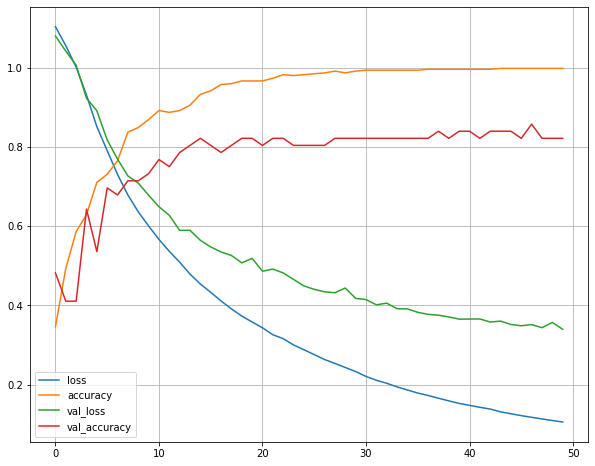

In [ ]:
def plot_history(x):
    import pandas as pd
    import matplotlib.pyplot as plt
    pd.DataFrame(x.history).plot(figsize=(10,8))
    plt.grid(True)
    # plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
    plt.show()  
plot_history(history)

In [ ]:
fmap_test = pretrained_model.predict(X_test)
results = mlp_model.evaluate(fmap_test, Y_test)
print("test loss: ", results[0],  "test acc: ", results[1])

1/1 [==============================] - 0s 27ms/step - loss: 0.3672 - accuracy: 0.8710
test loss:  0.36717745661735535 test acc:  0.8709677457809448


In [ ]:
mlp_model.save("/content/drive/MyDrive/ripe_fruit/vgg19-mlp-14-12.h5")
